# Analysis of LIG Attributions


TODOS:
- compare BERT distilBERT
- fix viz html to png
- vocab counts and attributions, overall & by class
- analyze what role position plays, any correls with attribution? esp. start / end


FRAGEN Michi/Lisanne:
- run BERT over whole test set?
- re-run with delta? do we need delta? (showing how "sure" about attributions)

## Imports, read & clean up data

In [1]:
import ast
import matplotlib.pyplot as plt
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from captum.attr import visualization as viz
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from _stop_words import ENGLISH_STOP_WORDS

%matplotlib inline

In [2]:
# convert strings into lists
def literal_eval_column(column):
    try:
        return ast.literal_eval(column)
    except (SyntaxError, ValueError):
        return column


def read_dfs(directory):
    dataframes = []

    for filename in os.listdir(directory):
        if filename.endswith('.csv'):  # Check if the file is a CSV file
            file_path = os.path.join(directory, filename)
            df = pd.read_csv(file_path)
            dataframes.append(df)

    # Merge the DataFrames into a single DataFrame (concatenate in this case)
    merged_df = pd.concat(dataframes, ignore_index=True)
    pd.set_option('display.max_colwidth', None)
    merged_df = merged_df.applymap(literal_eval_column)
    return merged_df

In [4]:
# check erroneous indices 
with open('nohup-att-dist4.out', 'r', encoding='utf-8') as f:
    lines = f.readlines()
error_indices = [int(l.split(' ')[0]) for l in lines[7:] if l]

In [ ]:
merged_df = read_dfs(directory='outputs/distilbert/')
filtered = merged_df.dropna(subset='tokens')
# 215 empty strings in data, also some only one-char instances
len(filtered)

In [5]:
gold = pd.read_csv('outputs/20newsgroups_test.csv', encoding='utf-8')
# exclude erroneous lines
gold = gold[~gold.index.isin(error_indices)]
gold = gold.reset_index()

def compare_pred(row):
    return 1 if row['label_pred'] == gold['label_text'][row.index] else 0

filtered = filtered.reset_index()
filtered['label_gold'] = gold['label_text']
filtered['correct'] = filtered.label_gold == filtered.label_pred
filtered['sum_attributions'] = filtered['attributions'].apply(lambda x: sum(x) if isinstance(x, list) else None)
filtered = filtered.drop(columns=['0', 'Unnamed: 0'])
assert len(gold) == len(filtered)

In [107]:
filtered.tail()

index  \
7304   8148   
7305   8149   
7306   8150   
7307   8151   
7308   8152   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     attributions  \
7304                 [0.2254657002475486, 0.009065115322021058, -0.009150316763236062, -0.003143106979051881, -0.010697206380851495, 0.015213552445164289, -0.012899985830261302, 0.003563101235427921, 0.02441977485606486, -0.02644572075539405, 0.003117124293401044, 0.0016459422438876545, 0.017735771224790767, 0.0014874084580332628, -0.002444519516378151, 0.012524575278730186, 0.002173285318971033, -0.019771825140241554, -0.010258781664755894, 0.05800394050365725, 0.06579421001692458, 0.3017866427337154, 0.7253727412531141, -0.1309454823518646, 0.007148792094533798, -0.0012682902208346653, 0.007311723870991411, 0.00855368187734296, 0.14946534147610613, 0.02274758555754188, 0.007517953980450321, 0.03123912866547899, 0.02351463663876976, 0.09068084539782145, 0.009651181832458488, -0.007787446035201727, -0.0016140915639375343, 0.00088231799596552, 0.002550103514493196, 0.006930068036884605, -0.009214827514207631, -0.014201150662519672, 0.008450469082570418, 0.01802302026299982, 0.025666058692756576, -0.0014952033536586183, 0.06005559753475892, -0.009985599324509917, 0.014668800002905805, 0.03958682670933471, 0.0008235978272093267, 0.06436781276939971, 0.02401185652930182, -0.007792828089185653, -0.0100490395741241, -0.01088665726432056, -0.006495650218366321, 0.001718002444218399, 0.0024624305338297858, 0.011743060197204613, -0.02431484447591137, -0.004405267183521738, 0.00783764129310171, -0.0009158359166360939, 0.001462495053580161, 0.0015003241907410266, 0.006979489684770939, 0.12024286394897604, 0.2584192939431191, 0.21655204131772654, -0.06119288860435151, -0.10145212352554953, 0.02513794556005513, 0.0150504324799851, -0.01220766726502778, -0

### Analyze attributions dataframe (min, max, correlations)

In [14]:
min(filtered.sum_attributions), max(filtered.sum_attributions)

(-1.3985433772675415, 14.190087651709247)

In [21]:
# corrcoeff (Pearson) = 0.25 -> weak or no correl
np.correlate(filtered.score, filtered.sum_attributions), np.corrcoef(filtered.score, filtered.sum_attributions)

(array([649.79005612]),
 array([[1.        , 0.25077146],
        [0.25077146, 1.        ]]))

In [22]:
np.corrcoef(filtered.score, filtered.tokens.apply(len))

array([[1.        , 0.24366537],
       [0.24366537, 1.        ]])

### Visualizations

In [9]:
def plot_instance(row, output=''):
    a = pd.Series(row['attributions'].tolist()[0], row['tokens'].tolist()[0])
    a.plot.barh(figsize=(10,20))
    if output:
         plt.savefig(f'{output}/{str(row.index[0])}.png', bbox_inches='tight')

In [55]:
from IPython.display import HTML, display, Image
import imgkit

def viz_row(row, output_path=''):
    viz_record = viz.VisualizationDataRecord(
        word_attributions=row['attributions'],
        pred_prob=row['score'],
        pred_class=row['label_pred'],
        true_class=row['label_gold'],
        # in LIG: target set to None, so defaults usually to target class, i.e. gold label?
        attr_class=row['label_gold'],
        attr_score=sum(row['attributions']),
        raw_input_ids=row['tokens'],
        convergence_score=0.)  # not needed for visualize_text
    # https://github.com/pytorch/captum/blob/b84980a8a7c4722f29b9693234bc255150da224a/captum/attr/_utils/visualization.py#L833
    visualization = viz.visualize_text([viz_record])
    if output_path:  # save to png
        Image(filename=output_path)
        #display(img)

In [57]:
viz_row(filtered.iloc[4], output_path='outputs/viz-distilbert/visualization.png')

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/viz-distilbert/visualization.png'

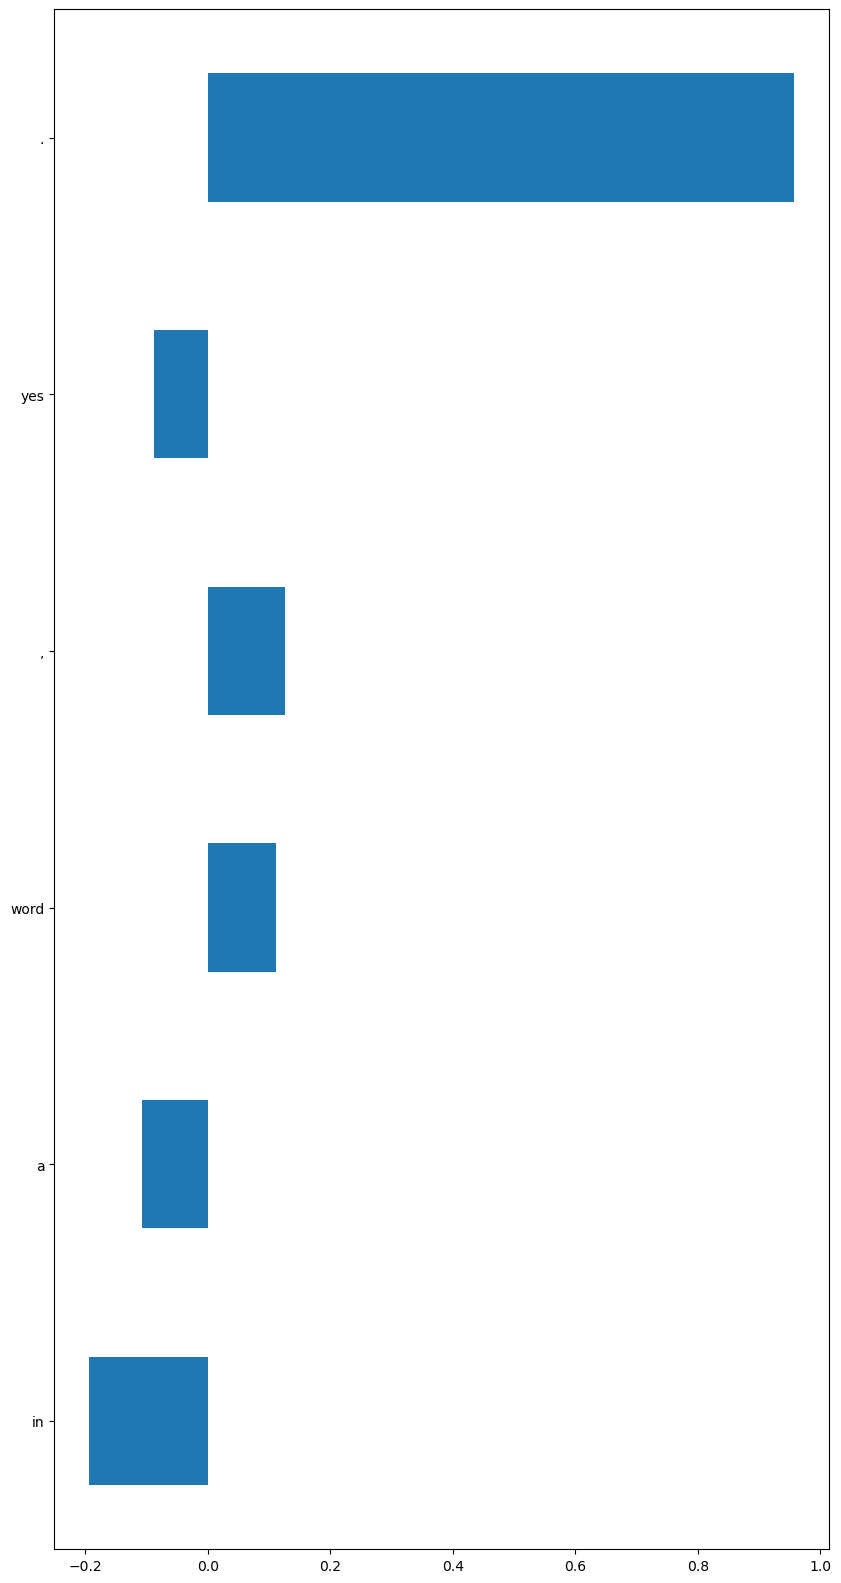

In [11]:
plot_instance(merged_df.iloc[[2]], output='outputs/viz-bert')

## Overall vocabulary & attributions analysis

In [6]:
labels = [
    "alt.atheism",
    "comp.graphics",
    "comp.os.ms-windows.misc",
    "comp.sys.ibm.pc.hardware",
    "comp.sys.mac.hardware",
    "comp.windows.x",
    "misc.forsale",
    "rec.autos",
    "rec.motorcycles",
    "rec.sport.baseball",
    "rec.sport.hockey",
    "sci.crypt",
    "sci.electronics",
    "sci.med",
    "sci.space",
    "soc.religion.christian",
    "talk.politics.guns",
    "talk.politics.mideast",
    "talk.politics.misc",
    "talk.religion.misc"
]

In [7]:
vocab_attributions = dict()
vocab_attributions_by_class = {label: dict() for label in labels}
vocab_counts = dict()
vocab_counts_by_class = dict()

ignore_stopwords = False
merge_subwords = True
aggregate = 'mean'

def dict_entries(token, attribution, by_class=True):
    if token in vocab_attributions:
            vocab_attributions[token].append(attribution)
    else:
        vocab_attributions[token] = [attribution]
    if by_class:
        if token in vocab_attributions_by_class[label]:
            vocab_attributions_by_class[label][token].append(attribution)
        else:
            vocab_attributions_by_class[label][token] = [attribution]


for k, row in filtered.iterrows():
    if type(row['tokens']) == float:
        continue
    assert len(row['attributions']) == len(row['tokens'])
    label = row['label_gold']
    # skip merged tokens
    skip_next_iteration = 0
    # iterate over tokens to save attributions
    for i, token in enumerate(row['tokens']):
        if skip_next_iteration != 0:
            skip_next_iteration -= 1
            continue
        if token:
            word = token
            attribution = row['attributions'][i]
            # detokenize
            if merge_subwords:
                # check whether next token starts with ##
                if i < len(row['tokens'])-1 and row['tokens'][i+1].startswith('##'):
                    # check whether further tokens start with ##
                    to_merge = row['tokens'][i:]
                    count = 1
                    iterator = iter(to_merge[1:])
                    while True:
                        try:
                            token = next(iterator)
                            if token.startswith("##"):
                                count += 1
                            else:
                                break
                        except StopIteration:
                            break
                    to_merge = to_merge[:count]
                    j = len(to_merge)
                    word = ''.join(row['tokens'][i:i+j]).replace('##', '')
                    attr = [row['attributions'][i:i+j]]
                    if aggregate == 'mean':
                        attribution = np.mean(attr)
                    skip_next_iteration = count-1
            # skip stop words
            if ignore_stopwords:
                if word in ENGLISH_STOP_WORDS:
                    continue
            # create or update dict entries with attributions
            dict_entries(word, attribution)
    # check on 1 instance only to start with
    #break


if ignore_stopwords:
    assert set(vocab_attributions.keys()).intersection(ENGLISH_STOP_WORDS) == {}


In [37]:
vocab_attributions_by_class

{'alt.atheism': {'in': [-0.19382938156955007,
   0.037745199185423794,
   0.03348229484877157,
   -0.0069002932884402925,
   0.005088587792657234,
   -0.01766677445111239,
   0.010027899801640284,
   -0.0017788840982321005,
   -0.005096426297986955,
   0.00788898830926347,
   -0.007329852162658207,
   -0.005368477216538616,
   0.05799464041065173,
   -0.013754701483842939,
   0.025821155130160634,
   0.022274810475093512,
   0.03301198982957887,
   0.003408437863668047,
   0.0035403664781250223,
   0.046443783264201274,
   0.01222256074105702,
   0.004690995071816764,
   0.020401640041024113,
   -0.0002173548859186238,
   0.05902917580495643,
   0.06345116272584787,
   -0.037077758292107334,
   0.06297322432691717,
   0.09994817868886631,
   0.004406283375716583,
   0.007622460221867813,
   0.003795749052586507,
   -0.0014702520918067684,
   0.0158466459645588,
   0.010819240601781691,
   0.000620741145010521,
   0.004447132516821423,
   -0.0009460613398302691,
   -0.004971333367652246

In [8]:
average_attr_by_class = {
    label: {
        token: np.mean([a for a in attr if isinstance(a, float)])
        for token, attr in labeldict.items()
    }
    for label, labeldict in vocab_attributions_by_class.items()
}

average_attr_by_class

{'alt.atheism': {'in': 0.010350806168192193,
  'a': 0.018906454562130356,
  'word': 0.05548777191790872,
  ',': 0.014501542223676687,
  'yes': 0.0009668648784938898,
  '.': 0.006664176550735332,
  'probably': 0.006177638488585817,
  'because': 0.009553180700561263,
  'it': 0.008141145374898164,
  'is': 0.011079131193100005,
  'rape': -0.06423984369862748,
  'so': 0.00875163298271794,
  'nothing': 0.011737295852016143,
  'may': 0.0034299397053873465,
  'work': 0.003063601553269253,
  'for': 0.0006876477687251775,
  'some': 0.007846193884042077,
  'but': 0.011771614513321555,
  'not': 0.0065649724833446756,
  'others': 0.011819279317229722,
  ':': 0.01127027195378619,
  'doesn': 0.012042113624232355,
  "'": 0.015968758452531397,
  't': 0.005500442759490368,
  'give': -0.004035659863033375,
  'any': 0.01179373351970375,
  'insight': 0.0277728855655861,
  'into': 0.017207664420295345,
  'an': 0.011680154584882179,
  'overall': 0.0007348789696913955,
  'god': 0.19689108628142363,
  'or': 0.

In [110]:
def sort_attr_dict(attr_dict):
    return dict(sorted(attr_dict.items(), key=lambda item: item[1], reverse=True))

In [111]:
len(set(average_attr_by_class["comp.os.ms-windows.misc"].keys()).intersection(set(average_attr_by_class["alt.atheism"].keys()))), \
len(set(average_attr_by_class["comp.os.ms-windows.misc"].keys()).difference(set(average_attr_by_class["alt.atheism"].keys())))

(2089, 3181)

In [112]:
len(set(average_attr_by_class["rec.motorcycles"].keys()).intersection(set(average_attr_by_class["alt.atheism"].keys()))), \
len(set(average_attr_by_class["rec.motorcycles"].keys()).difference(set(average_attr_by_class["alt.atheism"].keys())))

(2236, 3462)

In [113]:
sort_attr_dict(average_attr_by_class["alt.atheism"])

{'torah': 0.8946556105685459,
 'orbit': 0.8546828077404595,
 'heaven': 0.7760791843940474,
 'denomination': 0.7361201039831206,
 'gogh': 0.717660822401483,
 'prayer': 0.7042795988402561,
 'hebrew': 0.6768664017387269,
 'verb': 0.6209632433697962,
 'judaism': 0.6143038439717949,
 'christian': 0.5684182418121474,
 'soul': 0.5673833567912817,
 'default': 0.556653198802481,
 'gravitational': 0.5336895420875813,
 'weapon': 0.5329304508972978,
 'lyndon': 0.48430580968723597,
 'humanism': 0.4573461147674056,
 'charles': 0.4525712592256117,
 'islamic': 0.44497439500218183,
 'cooper': 0.4413515261864065,
 'noonan': 0.43497975758490887,
 'demon': 0.4324405969959177,
 'anarchist': 0.42754204138955004,
 'nasa': 0.4244598865235582,
 'prophetic': 0.4165009300929328,
 'luther': 0.40705963660678596,
 'dualism': 0.39790622355231003,
 'greeks': 0.3961972311060816,
 'weapons': 0.39503520913680096,
 'enemy': 0.3932885029757324,
 'gunman': 0.38574866903196847,
 'vor': 0.38555636734362575,
 'leather': 0.384

In [9]:
# save vocab counts and attribution means to df
df = pd.DataFrame(columns=['type', 'overall_count', 'overall_attr'] +
                  [f'{label}_count'for label in labels] +
                  [f'{label}_attr' for label in labels])

vocab = set(vocab_attributions.keys())
print(len(vocab))

for v in tqdm(vocab):
    v_dict = {
                'type': v,
                'overall_count': len(vocab_attributions[v]),
                'overall_attr': np.mean(vocab_attributions[v])
            } 
    for l in labels:
        if v in vocab_attributions_by_class.keys():
            v_dict[f'{label}_count'] = len(vocab_attributions_by_class[l][v])
            v_dict[f'{label}_attr'] = average_attr_by_class[l][v]
        else:
            v_dict[f'{label}_count'] = 0
            v_dict[f'{label}_attr'] = None
    new_row = pd.DataFrame([v_dict])
    df = df.append(new_row, ignore_index=True)

43124


  0%|          | 0/43124 [00:00<?, ?it/s]

C:\Users\lydia\AppData\Local\Temp\ipykernel_8344\2505451495.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
C:\Users\lydia\AppData\Local\Temp\ipykernel_8344\2505451495.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
C:\Users\lydia\AppData\Local\Temp\ipykernel_8344\2505451495.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
C:\Users\lydia\AppData\Local\Temp\ipykernel_8344\2505451495.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
C:\Users\lydia\AppDa

In [ ]:
df.to_csv('outputs/vocab_attr_dist4.csv')

Empty DataFrame
Columns: [type, overall_count, overall_attr, alt.atheism_count, comp.graphics_count, comp.os.ms-windows.misc_count, comp.sys.ibm.pc.hardware_count, comp.sys.mac.hardware_count, comp.windows.x_count, misc.forsale_count, rec.autos_count, rec.motorcycles_count, rec.sport.baseball_count, rec.sport.hockey_count, sci.crypt_count, sci.electronics_count, sci.med_count, sci.space_count, soc.religion.christian_count, talk.politics.guns_count, talk.politics.mideast_count, talk.politics.misc_count, talk.religion.misc_count, alt.atheism_attr, comp.graphics_attr, comp.os.ms-windows.misc_attr, comp.sys.ibm.pc.hardware_attr, comp.sys.mac.hardware_attr, comp.windows.x_attr, misc.forsale_attr, rec.autos_attr, rec.motorcycles_attr, rec.sport.baseball_attr, rec.sport.hockey_attr, sci.crypt_attr, sci.electronics_attr, sci.med_attr, sci.space_attr, soc.religion.christian_attr, talk.politics.guns_attr, talk.politics.mideast_attr, talk.politics.misc_attr, talk.religion.misc_attr]
Index: []

[0 rows x 43 columns]

In [ ]:
with open('outputs/vocab-test.txt', 'w', encoding='utf-8') as f:
    for v in sorted(vocab):
        f.write(f'{v}\n')

## BERT & DistilBERT comparison

In [ ]:
# read BERT, processed first 1000 instances only
merged_df_bert = read_dfs(directory='outputs/bert/')
filtered_bert = merged_df_bert.dropna(subset='tokens')
len(filtered_bert)

In [ ]:
# compare to distilbert
filtered_distilbert = filtered.iloc[:len(filtered_bert)]
assert len(filtered_bert) == len(filtered_distilbert)